In [2]:
import s3fs
import xarray as xr 
import numpy as np 
import cmocean
import matplotlib.pyplot as plt 

In [3]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, 
                             #combine='by_coords',
                             compat='override')
    return dset

In [5]:
ds = open_s3fs('quiver-data/*.nc')

In [7]:
ds = ds.rename({'__xarray_dataarray_variable__' : 'botvel'})
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
    depthu         (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    depthv         (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
Dimensions without coordinates: x, y
Data variables:
    botvel         (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [32]:
# Velocity data 
u = ds.vozocrtx.isel(y=slice(650,1800), x=slice(200,1400))*73
v = ds.vomecrty.isel(y=slice(650,1800), x=slice(200,1400))*73 #*73 pga dataen ble laget med /73?
vel = (u**2 + v**2)**0.5

In [33]:
# Smoothening Velocity data
us = u.rolling(x=10).mean()
vs = v.rolling(y=10).mean()
vels = (us**2 + vs**2)**0.5

In [28]:
us.shape

(75, 1200, 930)

In [34]:
# Quiver
c = 15
N = 100

x = np.linspace(0, 1200, 1200)
dx = 20 
x.shape

y = np.linspace(0, 930, 930)
dy = 20
y.shape

X, Y = np.meshgrid(x, y)
print(X.shape)
print(us.shape)


(930, 1200)
(75, 1150, 1200)


In [35]:
# chooseing a level to look at 
level = 14
depth = ds.depth[level].values
print(depth)

y_grid = np.array(Y.T[650:1800:dx, 200:1400:dy])
print(y_grid.shape)
x_grid = np.array(X.T[650:1800:dx, 200:1400:dy])
u_grid = np.array(us[level,650:1800:dx, 200:1400:dy].values)#endring
print(u_grid.shape)
v_grid = np.array(vs[level, 650:1800:dx, 200:1400:dy].values)
vel_grid = np.array(vels[level,650:1800:dx, 200:1400:dy].values)


30.874561
(28, 37)
(25, 50)


<ipython-input-36-ea7e109cf0fa>:11: RuntimeWarning: invalid value encountered in true_divide
  u_grid/vel_grid,
<ipython-input-36-ea7e109cf0fa>:12: RuntimeWarning: invalid value encountered in true_divide
  v_grid/vel_grid,


ValueError: Argument U has a size 1250 which does not match 1036, the number of arrow positions

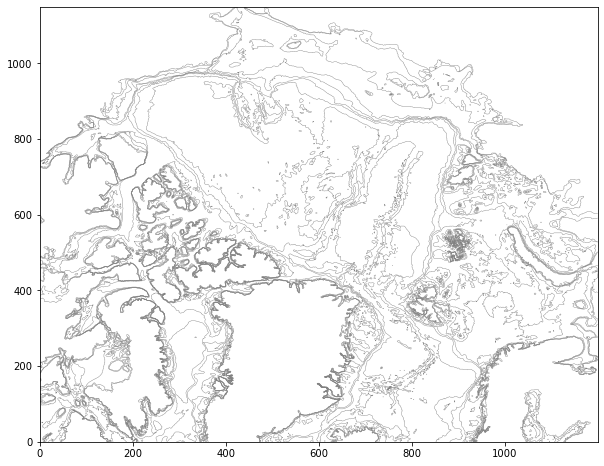

In [36]:
# plotting the quiver
#warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap_r = plt.get_cmap('magma_r')
cmap_o = plt.get_cmap(cmocean.cm.speed)
ax.contour(ds.mbathy.isel(y=slice(650,1800), x=slice(200,1400)), colors='grey', levels=8, linewidths=0.4)

c = ax.quiver(y_grid, 
        x_grid,
        u_grid/vel_grid,
        v_grid/vel_grid,
        vel_grid,
        scale = 40,  
        width=0.003,
        #headwidth=2,
        #headlength=1,
        cmap = cmap_o) 
ax.set_aspect('equal')

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)
plt.title(f'Quiverplot of the current at '+ str(depth) + 'm depth')